# Обучение ResNet18 на векторном представлении ЭКГ

## Импорт библиотек и написанных алгоритмов

In [1]:
# Стандартные библиотеки для работы с данными:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import datasets,models,layers
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam

# Библиотеки для построения архитектуры ResNet18
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf

# Библиотеки для формирования наборов данных:
import sys
import os
from importlib import reload

In [2]:
# Подгружаем пути к директориям с нашими алгоритмами:
cur_dir = os.getcwd()
dataset_path = os.path.join(cur_dir, "../Dataset")
wavelets_path = os.path.join(cur_dir, "../Wavelet")
script_path = os.path.join(cur_dir, "../Scripts")
print(script_path)
print(wavelets_path)
sys.path.append(dataset_path)
sys.path.append(wavelets_path)
sys.path.append(script_path)

C:\Users\F2PC\ЭКГшные приколдесы\RemoteMonitoring\Neural network\../Scripts
C:\Users\F2PC\ЭКГшные приколдесы\RemoteMonitoring\Neural network\../Wavelet


In [3]:
# Подгружаем алгоритмы для подготовки данных:
import ECGsignal as ecg # Алгоритмы для формирования датасета и цельного изображения графиков 12 отведений ЭКГ
reload(ecg) # Это для отображения изменений в файле без прерывания ядра
import VECG as vecg # Алгоритмы для формирования векторного представления кардиоциклов
reload(vecg)
import CWT as wt # Алгоритмы для вейвлет преобразования графиков ЭКГ
reload(wt)
import image as img
reload(img)

C:\Users\F2PC\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


<module 'image' from 'C:\\Users\\F2PC\\ЭКГшные приколдесы\\RemoteMonitoring\\Neural network\\../Scripts\\image.py'>

## Подготовка данных

In [4]:
# Инициализируем наш алгоритм загрузки данных
ecg.init()





# Создаём датафрейм и настраиваем количество записей каждого из классов
data_size = 330
ECG_df = ecg.signal(number_labels = {"SR" : data_size, "VA" : data_size, "AF" : data_size})
"""
Здесь мы создаём датафрейм из графиков ЭКГ каждой записи. 
В параметре 'number_labels' вписывается словарь вида {'Класс недуга' : количество записей по этому классу}.
В нашей задаче выделены три основных класса по записям:
SR - Синусовый ритм, VA - Различные виды аритмии, AF - Фибрилляция предсердия.
 
Желательно, чтобы количество рассматриваемых записей было соизмеримо между классами.
"""




ECG_df # Выводим полученный датафрейм, где слева матрица 12 на 2500, представляющая отсчёты 12 отведений записи,
# а справа - класс, присвоенный записи

,data,label
0,"[[0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0....",VA
1,"[[0.635, 0.635, 0.635, 0.634, 0.636, 0.635, 0....",VA
2,"[[-0.095, -0.095, -0.095, -0.095, -0.095, -0.0...",VA
3,"[[-0.015, -0.015, -0.015, -0.015, -0.015, -0.0...",VA
4,"[[0.085, 0.085, 0.085, 0.085, 0.085, 0.085, 0....",VA
...,...,...
985,"[[-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0...",SR
986,"[[-0.005, -0.005, -0.005, -0.005, -0.005, -0.0...",SR
987,"[[-0.07, -0.07, -0.07, -0.07, -0.07, -0.07, -0...",SR
988,"[[-0.08, -0.08, -0.08, -0.08, -0.08, -0.08, -0...",SR


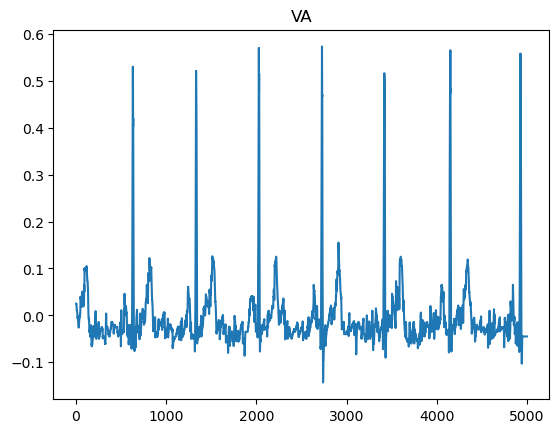

In [5]:
plt.plot(ECG_df.iloc[0,0][0])
plt.title(ECG_df.iloc[0,1]);

## Преобразование в новые типы данных

**Здесь будет представлен выбор, в какой из типов данных превратить наши выборки:**
1. Изображение со смещёнными в нём графиками отведений ЭКГ
2. Проекция векторного представления кардиоцикла в записи
3. Представление отведений как спектрограмм, полученых с использованием вейвлетов

### 2. Представление данных как проекции вектора кардиоцикла

In [6]:
vecg.init(filtering=True, canc_showing=True, plot3D=False)
vecg.make_vecg_df(ECG_df, 0, 4)

,data,label,XY,YZ,ZX
0,"[[0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0....",VA,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1,"[[0.635, 0.635, 0.635, 0.634, 0.636, 0.635, 0....",VA,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
2,"[[-0.095, -0.095, -0.095, -0.095, -0.095, -0.0...",VA,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
3,"[[-0.015, -0.015, -0.015, -0.015, -0.015, -0.0...",VA,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
4,"[[0.085, 0.085, 0.085, 0.085, 0.085, 0.085, 0....",VA,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
...,...,...,...,...,...
985,"[[-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0...",SR,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
986,"[[-0.005, -0.005, -0.005, -0.005, -0.005, -0.0...",SR,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
987,"[[-0.07, -0.07, -0.07, -0.07, -0.07, -0.07, -0...",SR,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
988,"[[-0.08, -0.08, -0.08, -0.08, -0.08, -0.08, -0...",SR,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."


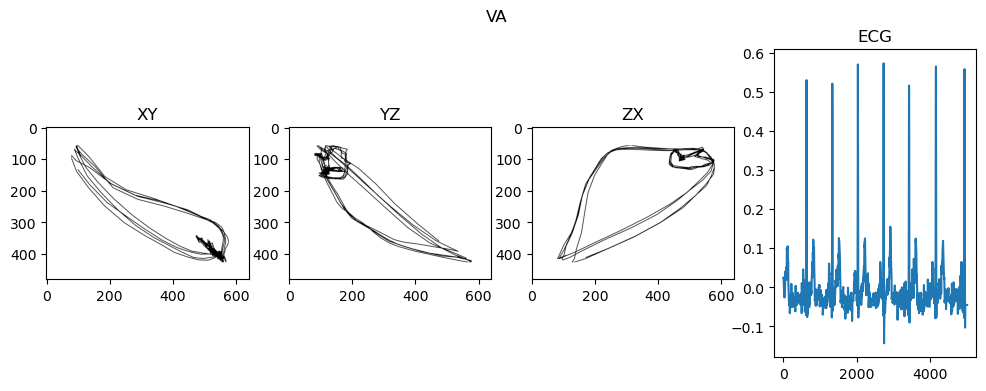

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 1, ncols = 4, figsize = (12,4))

i = 0

fig.suptitle(ECG_df.iloc[i,1])
ax1.imshow(ECG_df.iloc[i,2], cmap = 'gray')
ax1.set_title('XY')
ax2.imshow(ECG_df.iloc[i,3], cmap = 'gray')
ax2.set_title('YZ')
ax3.imshow(ECG_df.iloc[i,4], cmap = 'gray')
ax3.set_title('ZX');
ax4.plot(ECG_df.iloc[i,0][0])
ax4.set_title('ECG');

In [8]:
ECG_df = ECG_df.sample(frac = 1) # Вручную перемешиваем датафрейм
# Формируем непосредственно набор данных и меток:
X_ECG = np.array([ECG_df.iloc[:,2].tolist(),
                 ECG_df.iloc[:,3].tolist(),
                 ECG_df.iloc[:,4].tolist()])
X_ECG = np.transpose(X_ECG, (1, 2, 3, 0))
X_ECG[X_ECG == 255 ] = 0
X_ECG[X_ECG != 0] = 255
y_ECG = np.array(ECG_df.iloc[:,1].tolist())

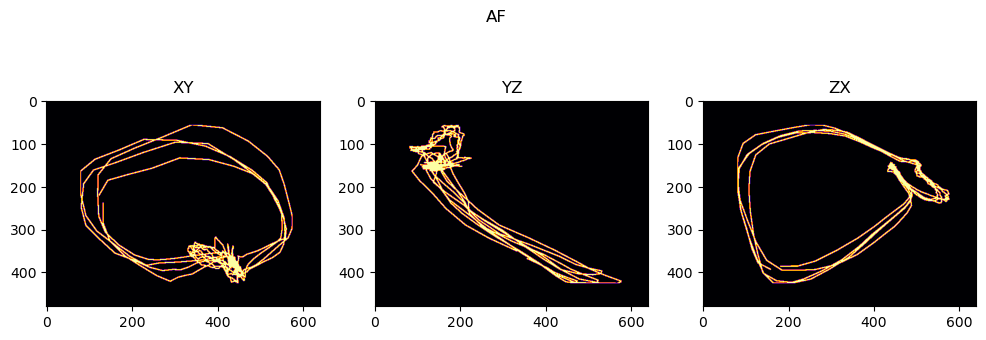

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4))

i = 0

fig.suptitle(y_ECG[i])
ax1.imshow(X_ECG[i,:,:,0], cmap = 'inferno')
ax1.set_title('XY')
ax2.imshow(X_ECG[i,:,:,1], cmap = 'inferno')
ax2.set_title('YZ')
ax3.imshow(X_ECG[i,:,:,2], cmap = 'inferno')
ax3.set_title('ZX');

## Разбиение на тренировочную и тестовую выборки + OneHotEncoder

In [10]:
# Производим деление выборки на тренировочную и тестовую
X_train, X_test = (X_ECG[:int(data_size *10/11)*3], X_ECG[int(data_size *10/11)*3:data_size*3])
y_train, y_test = (y_ECG[:int(data_size *10/11)*3], y_ECG[int(data_size *10/11)*3:data_size*3])
"""
Здесь можно покрутить параметры разбивки данных на тренировочные и тестовые - настроить процентаж разбвики, например.
"""





# Нормируем данные
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0 * 0.99 + 0.01
X_test = X_test / 255.0 * 0.99 + 0.01

# Производим энкодинг полученных меток классов в удобный для обработки сетью вид
print('Метка класса перед энкодингом:', y_train[:10])
encoder = OneHotEncoder()
encoder.fit(y_train.reshape(-1, 1))
y_train = encoder.transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()
print('Метка класса после энкодинга:', y_train[:10])
encoder.categories_

Метка класса перед энкодингом: ['AF' 'VA' 'SR' 'VA' 'SR' 'SR' 'VA' 'VA' 'AF' 'VA']
Метка класса после энкодинга: [[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


[array(['AF', 'SR', 'VA'], dtype='<U2')]

## Написание класса нейронной сети на основе ResNet18 и её компоновка

***Тут не знаю, что можно поменять, т.к. если менять саму архитектуру, то засесть можем тут надолго. Предложение было сконцентрироваться на одной архитектуре, поэтому советую пока внутренности класса не доставать и не менять :3***

In [28]:
"""
Стандартный блок архитектуры ResNet:
"""

class ResnetBlock(Model):
    
    def __init__(self, channels: int, down_sample=False): # channels: количество каналов = количество ядер свёртки

        super().__init__() # Перенимаем инициализируемые параметры у материнского класса Model

        self.__channels = channels # Задаём количество каналов (ядер свёртки)
        self.__down_sample = down_sample # Задаём параметр, отвечающий за сжатие
        self.__strides = [2, 1] if down_sample else [1, 1] # Задаём шаги ядер при свёртке
        # (в случае down_sample = True, шаг увеличивается в 2 раза и, следовательно, производится сжатие в 2 раза)

        KERNEL_SIZE = (3, 3) # Размер ядра
        INIT_SCHEME = "he_normal" # Закон генерации весов в ядре (здесь нормальный закон)

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME) # Первый слой 2D свёртки
        self.bn_1 = BatchNormalization() # Нормализация значений, полученных на предыдущем слое
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME) # Второй слой 2D свёртки
        self.bn_2 = BatchNormalization()
        self.merge = Add() # Слой поэлементного сложения (пока ничего не складывает, сложение будет дальше)

        if self.__down_sample:
            # Производим сжатие данных в случае down_sample = True
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs # Сохраняем исходные данные
        
        # Производим обработку входных данных по слоям блока:
        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out # Выводим результат обработки блоком ResNet входных данных


"""
Непосредственно архитектура ResNet18:
"""

class ResNet18(Model):

    def __init__(self, num_classes, **kwargs): # num_classes: количество классов в решаемой задаче

        super().__init__(**kwargs)
        
        
        # Собираем архитектуру из готовых блоков, созданных нами ранее:
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(3, 3), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")
        
    def call(self, inputs):
        
        # Производим обработку входных данных по слоям сети:
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [29]:
model = ResNet18(3)






# Строим модель исходя из заложенного размера объектов
length = X_train.shape[1] # Длина картинки
width = X_train.shape[2] # Ширина картинки
channels = X_train.shape[3] # Количество картинок в одном объекте (число каналов)
model.build(input_shape = (None, length, width, channels))
"""
Если будут какие-то интересные идеи усечения размеров картинок, подаваемых на вход в нейронку,
то предлагаю здесь пошаманить с длиной, шириной и количеством каналов.
"""





# Используем категориальную кроссэнтропию для классов, представленных через one-hot encoding
opt = SGD(learning_rate = 0.0001) # Оптимизатор, предложенный в источнике
#opt = Adam(learning_rate = 0.0001)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_60 (Ba  multiple                  256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_3 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 resnet_block_24 (ResnetBlo  multiple        

## Обучение нейросети

In [30]:
es = EarlyStopping(patience= 20, restore_best_weights=True, monitor="val_accuracy")
batch = 25
STEPS = len(X_train) / batch
history = model.fit(
    X_train, y_train,
    steps_per_epoch=STEPS,
    batch_size = batch,
    epochs = 50,
    validation_data=(X_test, y_test),
    callbacks=[es]
)

Epoch 1/50
36/36 [==============================] - 254s 7s/step - loss: 1.3141 - accuracy: 0.3333 - val_loss: 2.1645 - val_accuracy: 0.3111
Epoch 2/50
36/36 [==============================] - 247s 7s/step - loss: 1.1952 - accuracy: 0.3333 - val_loss: 1.2010 - val_accuracy: 0.3778
Epoch 3/50
36/36 [==============================] - 241s 7s/step - loss: 1.1446 - accuracy: 0.3311 - val_loss: 1.1226 - val_accuracy: 0.3333
Epoch 4/50
36/36 [==============================] - 249s 7s/step - loss: 1.1217 - accuracy: 0.3344 - val_loss: 1.1147 - val_accuracy: 0.3333
Epoch 5/50
36/36 [==============================] - 258s 7s/step - loss: 1.1120 - accuracy: 0.3344 - val_loss: 1.1093 - val_accuracy: 0.3333
Epoch 6/50
36/36 [==============================] - 257s 7s/step - loss: 1.1066 - accuracy: 0.3344 - val_loss: 1.1049 - val_accuracy: 0.3667
Epoch 7/50
36/36 [==============================] - 253s 7s/step - loss: 1.1029 - accuracy: 0.3589 - val_loss: 1.1005 - val_accuracy: 0.4111
Epoch 8/50
36

KeyboardInterrupt: 

In [ ]:
y_pred = model.predict(X_test)
y_pred[:10]

In [ ]:
def plotmodelhistory(history): 
    
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    
    plt.show()

print(history.history.keys())
plotmodelhistory(history)

In [ ]:
ModelLoss, ModelAccuracy = model.evaluate(X_test, y_test)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

In [ ]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [ ]:
y_pred_test = encoder.inverse_transform(y_pred_test)
y_pred_train = encoder.inverse_transform(y_pred_train)
y_test_check = encoder.inverse_transform(y_test)
y_train_check = encoder.inverse_transform(y_train)

In [ ]:
print ('\n clasification report:\n', classification_report(y_test_check, y_pred_test))

print('Матрица несоответствий для тестовой выборки:\n')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_check, y_pred_test))
disp.plot(cmap = 'Blues', ax=ax);

In [ ]:
print ('\n clasification report:\n', classification_report(y_train_check, y_pred_train))

print('Матрица несоответствий для тренировочной выборки:\n')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix(y_train_check, y_pred_train))
disp.plot(cmap = 'Blues', ax=ax); 